In [1]:
import torch
import tensorflow as tf

import torch.utils.data as data
import torch.nn as nn
from torch import cat
import torch.nn.init as init
from torch.autograd import Variable

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn.metrics import top_k_accuracy_score

from io import BytesIO
import time
from random import shuffle

import os, sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
!wget -P /kaggle/working/permutations "https://github.com/bbrattoli/JigsawPuzzlePytorch/raw/master/permutations_1000.npy"

--2023-11-08 11:56:26--  https://github.com/bbrattoli/JigsawPuzzlePytorch/raw/master/permutations_1000.npy
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bbrattoli/JigsawPuzzlePytorch/master/permutations_1000.npy [following]
--2023-11-08 11:56:27--  https://raw.githubusercontent.com/bbrattoli/JigsawPuzzlePytorch/master/permutations_1000.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72080 (70K) [application/octet-stream]
Saving to: ‘/kaggle/working/permutations/permutations_1000.npy.1’

permutations_1000.n 100%[===================>]  70.39K  --.-KB/s    in 0.003s  

2023-11-08 11:56:27

In [15]:
PERMUTATION_SET_LEN = 1000
BATCH_SIZE = 256
LEARNING_RATE = 0.01
CORES = 4
CHECKPOINT = '/content'
START_EPOCH = 27
EPOCHS = 30
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PERMUTATIONS_DIR = '/kaggle/working/permutations/permutations_1000.npy'

## Image Loader

Files already downloaded and verified
<class 'tuple'> 50000
6


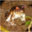

In [4]:
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
print(type(cifar_trainset[0]), len(cifar_trainset))
print(cifar_trainset[0][1])
cifar_trainset[0][0]

Files already downloaded and verified
<class 'tuple'> 10000
3


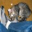

In [5]:
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
print(type(cifar_testset[0]), len(cifar_testset))
print(cifar_testset[0][1])
cifar_testset[0][0]

In [6]:
class CustomDataset(data.Dataset):
    def __init__(self, data, permutations_dir=PERMUTATIONS_DIR):
        self.data = data
        self.permutations = np.load(permutations_dir)

        self.image_transformer = transforms.Compose([
            transforms.Resize(256, Image.BILINEAR),
            transforms.CenterCrop(255)])
        self.augment_tile = transforms.Compose([
            transforms.RandomCrop(64),
            transforms.Resize((75, 75), Image.BILINEAR),
            transforms.Lambda(rgb_jittering),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        img = self.data[index][0]
        if img.size[0] != 255:
            img = self.image_transformer(img)

        s = float(img.size[0]) / 3
        a = s / 2
        tiles = [None] * 9
        for n in range(9):
            i = n / 3
            j = n % 3
            c = [a * i * 2 + a, a * j * 2 + a]
            c = np.array([c[1] - a, c[0] - a, c[1] + a + 1, c[0] + a + 1]).astype(int)
            tile = img.crop(c.tolist())
            tile = self.augment_tile(tile)
            # Normalize the patches indipendently to avoid low level features shortcut
            m, s = tile.view(3, -1).mean(dim=1).numpy(), tile.view(3, -1).std(dim=1).numpy()
            s[s == 0] = 1
            #norm = transforms.Normalize(mean=m.tolist(), std=s.tolist())
            #tile = norm(tile)
            tiles[n] = tile

        order = np.random.randint(len(self.permutations))
        data = [tiles[self.permutations[order][t]] for t in range(9)]
        data = torch.stack(data)

        return data, int(order), tiles

    def __len__(self):
        return len(self.data)


def rgb_jittering(im):
    im = np.array(im, 'int32')
    for ch in range(3):
        im[:, :, ch] += np.random.randint(-2, 2)
    im[im > 255] = 255
    im[im < 0] = 0
    return im.astype('uint8')

In [7]:
train_data = CustomDataset(cifar_trainset)
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            num_workers=CORES,
                                            pin_memory = False,
                                            drop_last = True,
                                            persistent_workers = True)
val_data = CustomDataset(cifar_trainset)
val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            num_workers=CORES,
                                            pin_memory = False,
                                            persistent_workers = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'list'> <class 'torch.Tensor'>
torch.Size([256, 9, 3, 75, 75]) torch.Size([256]) 9 torch.Size([256, 3, 75, 75])
tensor(463)


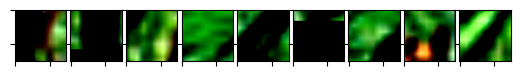

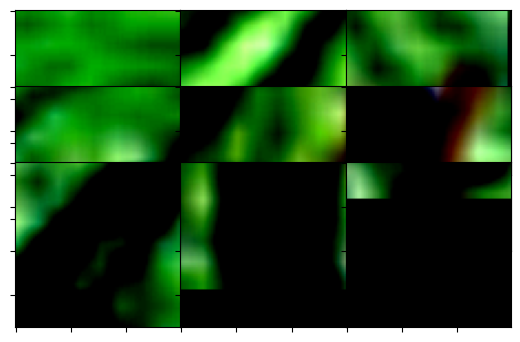

In [8]:
fig = plt.figure()
ofig = plt.figure()
for i, (images, labels, original) in enumerate(train_loader):
    if i>0:
        break
    print(type(images), type(labels), type(original), type(original[0]))
    print(images.shape, labels.shape, len(original), original[0].shape)
    # print(type(images[0][i].permute(1, 2, 0)), type(images[0][i].permute(1, 2, 0).numpy()), np.min(images[0][i].permute(1, 2, 0).numpy()), np.max(images[0][i].permute(1, 2, 0).numpy()))
    idx = 5
    print(labels[idx])
    # plt.imshow()
    for i in range(9):
        ax = ofig.add_subplot(3, 3, i+1)
        img = (np.clip((original[i][idx].permute(1, 2, 0).numpy().copy()), 0, 1)*255).astype(np.uint8)
        ax.imshow(img)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
    ofig.subplots_adjust(wspace=0, hspace=-0.65)
    for i in range(9):
        ax = fig.add_subplot(1, 9, i+1)
        img = (np.clip((images[idx][i].permute(1, 2, 0).numpy().copy()), 0, 1)*255).astype(np.uint8)
        ax.imshow(img)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
    fig.subplots_adjust(wspace=0.08, hspace=-0.65)
fig.show()
ofig.show()

## jigsaw network

In [9]:
class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=True):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1),
                    stride=1,padding=(int((local_size-1.0)/2), 0, 0))
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta


    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x

In [10]:
class Network(nn.Module):

    def __init__(self, PERMUTATION_SET_LEN=1000):
        super(Network, self).__init__()

        self.conv = nn.Sequential()
        self.conv.add_module('conv1_s1',nn.Conv2d(3, 96, kernel_size=11, stride=2, padding=0))
        self.conv.add_module('relu1_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool1_s1',nn.MaxPool2d(kernel_size=3, stride=2))
        self.conv.add_module('lrn1_s1',LRN(local_size=5, alpha=0.0001, beta=0.75))

        self.conv.add_module('conv2_s1',nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2))
        self.conv.add_module('relu2_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool2_s1',nn.MaxPool2d(kernel_size=3, stride=2))
        self.conv.add_module('lrn2_s1',LRN(local_size=5, alpha=0.0001, beta=0.75))

        self.conv.add_module('conv3_s1',nn.Conv2d(256, 384, kernel_size=3, padding=1))
        self.conv.add_module('relu3_s1',nn.ReLU(inplace=True))

        self.conv.add_module('conv4_s1',nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2))
        self.conv.add_module('relu4_s1',nn.ReLU(inplace=True))

        self.conv.add_module('conv5_s1',nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2))
        self.conv.add_module('relu5_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool5_s1',nn.MaxPool2d(kernel_size=3, stride=2))

        self.fc6 = nn.Sequential()
        self.fc6.add_module('fc6_s1',nn.Linear(256*3*3, 1024))
        self.fc6.add_module('relu6_s1',nn.ReLU(inplace=True))
        self.fc6.add_module('drop6_s1',nn.Dropout(p=0.5))

        self.fc7 = nn.Sequential()
        self.fc7.add_module('fc7',nn.Linear(9*1024,4096))
        self.fc7.add_module('relu7',nn.ReLU(inplace=True))
        self.fc7.add_module('drop7',nn.Dropout(p=0.5))

        self.classifier = nn.Sequential()
        self.classifier.add_module('fc8',nn.Linear(4096, PERMUTATION_SET_LEN))

        #self.apply(weights_init)

    def load(self,checkpoint):
        model_dict = self.state_dict()
        pretrained_dict = torch.load(checkpoint)
        pretrained_dict = {k: v for k, v in list(pretrained_dict.items()) if k in model_dict and 'fc8' not in k}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)
        print([k for k, v in list(pretrained_dict.items())])

    def save(self,checkpoint):
        torch.save(self.state_dict(), checkpoint)

    def forward(self, x):
        B,T,C,H,W = x.size()
        x = x.transpose(0,1)

        x_list = []
        for i in range(9):
            z = self.conv(x[i])
            z = self.fc6(z.view(B,-1))
            z = z.view([B,1,-1])
            x_list.append(z)

        x = cat(x_list,1)
        x = self.fc7(x.view(B,-1))
        x = self.classifier(x)

        return x


def weights_init(model):
    if type(model) in [nn.Conv2d,nn.Linear]:
        nn.init.xavier_normal(model.weight.data)
        nn.init.constant(model.bias.data, 0.1)


## jigsaw train

In [11]:
net = Network(PERMUTATION_SET_LEN).to(DEVICE)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=LEARNING_RATE,momentum=0.9,weight_decay = 5e-4)

In [13]:
def adjust_learning_rate(optimizer, epoch, init_lr=LEARNING_RATE, step=30, decay=0.1):
    """Sets the learning rate to the initial LR decayed by 10 every step_epoch"""
    lr = init_lr * (decay ** (epoch // step))
    print('Learning Rate %f'%lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def compute_accuracy(target, output, topk=(1,)):
    results = []
    for k_ in topk:
        # Calculate the top-k accuracy
        topk_accuracy = top_k_accuracy_score(y_true=target, y_score=output, k=k_, labels=np.arange(PERMUTATION_SET_LEN))
        results.append(topk_accuracy*100)

    # Return the top-k accuracy as a list (for consistency with the original function)
    return results

In [16]:
#load if previously trained
checkpoint = torch.load('/content/best.pth')
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [85]:
# Train the Model
best_loss = float('inf')
train_history_dict = {'loss': [], 'prec1': [], 'prec5': [], 'prec10': []}
for epoch in range(START_EPOCH, EPOCHS):
    start_time = time.time()
    train_loss, outputs_, labels_ = 0.0, [], []

    lr = adjust_learning_rate(optimizer, epoch, init_lr=LEARNING_RATE, step=10, decay=0.1)
    for images, labels, original in tqdm(train_loader, desc=f'Epoch {epoch}/{EPOCHS} - Training', leave=False):
        images = Variable(images).to(DEVICE)
        labels = Variable(labels).to(DEVICE)

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #saving per batch
        loss = float(loss.cpu().data.numpy())
        outputs = outputs.cpu().data.numpy()
        labels = labels.cpu().data.numpy()

        train_loss += loss
        outputs_.append(outputs)
        labels_.append(labels)

    #logging
    if train_loss < best_loss:
        training_status = {
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_loss': train_loss,
        }
        torch.save(training_status, CHECKPOINT+'/best.pth')
        print(f"model saved at epoch = {epoch}")

    prec1, prec5, prec10 = compute_accuracy(np.concatenate(labels_, axis=0), np.concatenate(outputs_, axis=0), topk=(1, 5, 10))
    train_history_dict['loss'].append(train_loss)
    train_history_dict['prec1'].append(prec1)
    train_history_dict['prec5'].append(prec5)
    train_history_dict['prec10'].append(prec10)

    end_time = time.time()
    #printing status
    print(f"epoch {epoch} took {end_time-start_time:.3f} seconds to complete")
    print(f"Train loss:{train_loss} | prec1:{prec1} | prec5:{prec5} | prec10:{prec10}")

    #save model at the end
    training_status = {
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_loss': train_loss,
        }
    torch.save(training_status, CHECKPOINT+'/last.pth')

## Grad-CAM

In [30]:
!pip install grad-cam -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 11.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [31]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [17]:
test_net = Network(PERMUTATION_SET_LEN).to(DEVICE)
t_layer = list(test_net.children())[0]

In [18]:
checkpoint = torch.load('/content/best.pth')
test_net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [71]:
image_idx = [0, 1, 2, 3]
cam_data_list = [cifar_testset[idx] for idx in image_idx]
cam_data = CustomDataset(cam_data_list)
cam_loader = torch.utils.data.DataLoader(dataset=cam_data,
                                            batch_size=len(image_idx),
                                         drop_last=False)
i_tensor, labels, original = next(iter(cam_loader))

In [75]:
img_n = np.asarray(cam_data_list[np.random.randint(len(image_idx)-1)][0].resize((75, 75)))/255

In [79]:
target_layers = [t_layer]
input_tensor = i_tensor# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=test_net, target_layers=target_layers, use_cuda=True)
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=None, aug_smooth=True,eigen_smooth=True)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img_n, grayscale_cam, use_rgb=True)

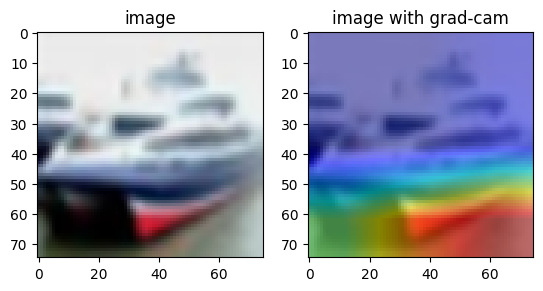

In [88]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_n)
ax1.set_title("image")

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(visualization)
ax2.set_title("image with grad-cam")

fig.show()